In [1]:
import yaml

In [2]:
# load menu
with open("menu.yml", 'r') as f:
    menu = yaml.safe_load(f)

In [3]:
if menu['all_stats']:
    import os
    import glob
    import math
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    from io import StringIO
    import requests
    from sklearn.preprocessing import MinMaxScaler
    from shapely.geometry import shape
    from shapely.ops import unary_union
    import pint
    import folium
    from pathlib import Path
    import matplotlib.pyplot as plt
    import requests
    import re
    import rasterio
    from rasterio.mask import mask
    from shapely.geometry import Point
    from fiona.crs import from_epsg
    from nbconvert import MarkdownExporter
    import nbformat
    import base64
    import pickle
    import plotly.graph_objects as go

In [4]:
url = "https://raw.githubusercontent.com/compoundrisk/monitor/databricks/src/country-groups.csv"
country_groups = pd.read_csv(url)

# Source helper functions
helpers_url = "https://raw.githubusercontent.com/compoundrisk/monitor/databricks/src/fns/helpers.R"
helpers_code = requests.get(helpers_url).text

# Define tolatin function
def tolatin(x):
    return stri_trans_general(x, id="Latin-ASCII")

# Define normalize function
def normalize(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min) / (x_max - x_min)

def print_text(x, linebreaks=2):
    print(x + "\n" + "<br>" * linebreaks)

read AOI shapefile


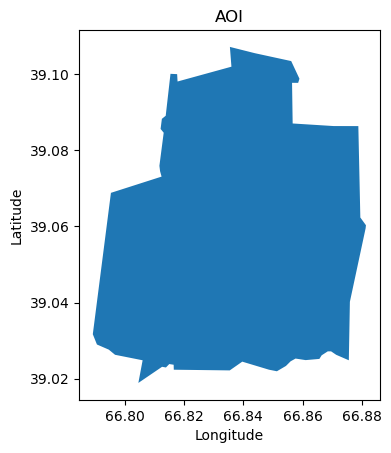

In [5]:
# SET UP ##############################################

# load city inputs files, to be updated for each city scan
with open("city_inputs.yml", 'r') as f:
    city_inputs = yaml.safe_load(f)

city = city_inputs['city_name'].replace(' ', '_').lower()
country = city_inputs['country_name'].replace(' ', '_').lower()
# load global inputs, such as data sources that generally remain the same across scans
with open("global_inputs.yml", 'r') as f:
    global_inputs = yaml.safe_load(f)

# Read AOI shapefile --------
print('read AOI shapefile')
# transform the input shp to correct prj (epsg 4326)
aoi_file = gpd.read_file(city_inputs['AOI_path']).to_crs(epsg = 4326)
features = aoi_file.geometry

# Define output folder ---------
output_folder = Path('output')

if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    
fig, ax = plt.subplots()
features.plot(ax=ax)
plt.title('AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [6]:
#AOI AREA
def calculate_aoi_area(features):
    # Create a unit registry
    ureg = pint.UnitRegistry()

    # Combine geometries using unary_union from shapely
    combined_geometry = unary_union(features)

    # Calculate the area in square kilometers
    area_km2 = combined_geometry.area / 1e6  # Convert square meters to square kilometers

    # Print the result using the pint library for unit formatting
    area_quantity = area_km2 * ureg.km**2
    return area_quantity.to('km^2')


area = calculate_aoi_area(features)

In [7]:
#Climate
def get_koeppen_classification():
    # Load global inputs from YAML file
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    # Calculate centroid of AOI
    centroid = features.centroid.values[0]

    # Retrieve centroid coordinates
    coords = {' Lon': centroid.x, 'Lat': centroid.y}

    # Read Köppen climate classification file
    koeppen_file_path = global_inputs.get('koeppen_source')
    koeppen = pd.read_csv(koeppen_file_path)

    # Filter Köppen data for the region around the centroid with a buffer of 0.5 degrees
    lon_min, lon_max = coords[' Lon'] - 0.5, coords[' Lon'] + 0.5
    lat_min, lat_max = coords['Lat'] - 0.5, coords['Lat'] + 0.5
    koeppen_city = koeppen[
        (koeppen[' Lon'].between(lon_min, lon_max)) &
        (koeppen['Lat'].between(lat_min, lat_max))
    ][' Cls'].unique()

    # Print Köppen climate classification
    koeppen_text = ', '.join(koeppen_city)
    print(f"Köppen climate classification: {koeppen_text} (See https://en.wikipedia.org/wiki/Köppen_climate_classification for classes)")

    # Return Köppen climate classification if needed
    return koeppen_city


In [8]:
#Get un data
def get_un_pop_growth():
    # Load global inputs from YAML file
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
    undata_file = global_inputs.get('un_data_source')

    # UN Data
    try:
        pop_growth_undata = pd.read_csv(undata_file, dtype={'Sex': 'str'}, nrows=69490)
        pop_growth_undata = pop_growth_undata[(pop_growth_undata['Country or Area'] == country) &
                                              (pop_growth_undata['Sex'] == 'Both Sexes') &
                                              (pop_growth_undata['City'].str.lower().str.contains(city.lower()))]
        pop_growth_undata = pop_growth_undata[['City', 'Year', 'Value']].rename(columns={'City': 'Location', 'Value': 'Population'})
        pop_growth_undata['Source'] = 'UN Data'
        pop_growth_undata['Year'] = pd.to_numeric(pop_growth_undata['Year'], errors='coerce')
        pop_growth_undata = pop_growth_undata.dropna(subset=['Year', 'Population']).sort_values('Year')

        return pop_growth_undata

    except FileNotFoundError:
        print(f"undata_file ({undata_file}) does not exist.")
        return None
        0

In [9]:
#Need Aziz's help on citypopulation.de

In [13]:
# # oxford data - needs to be turned into a function
# # Load configuration from YAML file

# city = "Mumbai'
# with open('global_inputs.yml', 'r') as f:
#     config = yaml.safe_load(f)
# oxford_file = global_inputs.get('oxford_global_source')
# oxford_full = pd.read_csv(oxford_file)
# pop = oxford_full.loc[(oxford_full['Location'] == city) & (oxford_full['Indicator'] == "Total population"), '2021']
# if not pop.empty:
#     print(f"pop: {pop.values[0] * 1000:,.0f}")  # Accessing the value and applying formatting
# else:
#     # Get population growth from UN and DE sources
#     pop_growth_un_de = pd.concat([get_un_pop_growth(city, country)])
#     # Get the latest population data and calculate mean population
#     pop = pop_growth_un_de.loc[pop_growth_un_de['Year'].idxmax(), 'Population'].mean()
    
#     # Print population
#     print(f"Current population of city is {pop * 1000:,.0f}")

#     if pd.isna(pop):  # Check if population is NaN
#         # Use manual population data
#         pop = population_manual / 1000  # Adjust as needed
# #oxford locations
# oxford_locations = global_inputs.get ('oxford_locations_source')
# oxford_locations = pd.read_csv(oxford_locations)
# # Define nearby countries string
# nearby_countries_string = "..."  # Define nearby countries string

# # Filter nearby cities
# nearby_cities = oxford_locations[
#     oxford_locations['Country'].str.lower().str.contains(nearby_countries_string.lower()) &
#     (oxford_locations['Location'] != oxford_locations['Country']) &
#     (~oxford_locations['Location'].str.contains("Total"))
# ]['Location'].tolist()

# # Select benchmark cities
# bm_cities = oxford_full[
#     (oxford_full['Location'].isin(nearby_cities)) &
#     (oxford_full['Indicator'] == "Total population") &
#     (((oxford_full['2021'] >= pop.iloc[0] * 0.5) & (oxford_full['2021'] <= pop.iloc[0] * 1.5)) | (oxford_full['Country'] == country)) &
#     (oxford_full['Location'] != city)
# ]['Location'].tolist()

# print(bm_cities)
# # Print table of population in benchmark cities
# print("Benchmark cities")
# benchmark_cities_df = oxford_full[
#     (oxford_full['Location'].isin(bm_cities)) &
#     (oxford_full['Indicator'] == "Total population")
# ][['Location', 'Country', 'Indicator', '2021']]
# benchmark_cities_df['2021'] *= 1000  # Convert population to thousands
# benchmark_cities_df = benchmark_cities_df.sort_values(by='Location')
# print(benchmark_cities_df)

# # Print table of population of nearby cities not in benchmark list
# print("\nNearby non-benchmark cities")
# nearby_non_benchmark_df = oxford_full[
#     (oxford_full['Location'].isin(nearby_cities)) &
#     (~oxford_full['Location'].isin(bm_cities)) &
#     (oxford_full['Indicator'] == "Total population")
# ][['Location', 'Country', 'Indicator', '2021']]
# nearby_non_benchmark_df['2021'] *= 1000  # Convert population to thousands
# nearby_non_benchmark_df = nearby_non_benchmark_df.sort_values(by='2021')
# print(nearby_non_benchmark_df)

# # Generate benchmark city text
# benchmark_text = (
#     oxford_full[(oxford_full['Location'].isin([city] + bm_cities))][['Location', 'Country']]
#     .drop_duplicates()
#     .sort_values(by='Country')
#     .groupby('Country')
#     .apply(lambda x: f"{', '.join(x['Location'])} ({x.iloc[0]['Country']})")
#     .reset_index(name='text')
#     .set_index('text')
#     .index
#     .tolist()
# )
# print("\nBenchmark footnote text:")
# print('\n'.join(benchmark_text))

# # Get unique countries from the Oxford data
# countries = oxford_full['Country'].unique()

# # Subset oxford_full DataFrame to include only countries data
# oxford_countries = oxford_full[
#     (oxford_full['Country'].isin(countries)) &
#     (oxford_full['Location'].str.contains("- Total") | oxford_full['Location'].isin(countries))
# ].drop(columns=['Location'])

# # Select indicators used in Oxford
# indicators = oxford_full['Indicator'].unique()

# # Filter indicators for population distribution, employment, and gross value added
# pop_dist_inds = [ind for ind in indicators if "Population" in ind and ind not in ["Population 0-14", "Population 15-64", "Population 65+"]]
# emp_inds = [ind for ind in indicators if "Employment" in ind]
# gva_inds = [ind for ind in indicators if "gross value added, real, us" in ind.lower()]

# # Additional indicators
# extra_inds = ["Total population", "Employment - Total", "GDP, real, US$ - Total"]


In [14]:
#pop growth graph

In [15]:
#pop density graph

In [16]:
#Population distribution (If in Oxford)

In [17]:
#Age Distribution by World Pop

In [18]:
#Age structure Oxford Economics (If in Oxford)

In [19]:
# Share of GDP, Emp, Pop (If in Oxford)

In [20]:
# GDP, Pop, Emp Growth (If in Oxford)

In [21]:
# GDP per capita (If in Oxford)

In [22]:
# Share of employment by sector (If in Oxford)

In [23]:
#Economic Inequality (If in Oxford)

In [9]:
def wsf_stats():
    # Load global inputs from YAML file
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    # Get city inputs
    city_inputs = global_inputs.get('city_inputs')

    if menu['wsf']:  
        wsf_stats_file = Path(output_folder / 'WSF.xlsx', sheet_name="WSF",index_col=0)  
        if os.path.exists(wsf_stats_file):  
            pass
        else:
            print("WSF stats file does not exist.")
            return  
        wsf = pd.read_excel(wsf_stats_file)
        
        wsf = wsf.rename(columns={'year': 'Year'}).\
        loc[:, ['Year', 'cumulative sq km']].\
        rename(columns={'cumulative sq km': 'uba_km2'})

        
        wsf['growth_pct'] = (wsf['uba_km2'] / wsf['uba_km2'].shift(1) - 1)
        wsf['growth_km2'] = wsf['uba_km2'] - wsf['uba_km2'].shift(1)

        # Plot
        plt.figure(figsize=(8, 6))
        plt.plot(wsf['Year'], wsf['uba_km2'], marker='o', linestyle='-')
        plt.title("Urban Built-up Area, 1985-2015")
        plt.xlabel("Year")
        plt.ylabel("Urban built-up area (km^2)")
        plt.grid(True)

        # Plotly
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=wsf['Year'], y=wsf['uba_km2'], mode='lines+markers', marker=dict(symbol='circle', size=8), line=dict(color='blue', width=2), name='Urban built-up area (km^2)'))
        fig.update_layout(
            title="Urban Built-up Area, 1985-2015",
            xaxis=dict(title="Year"),
            yaxis=dict(title="Urban built-up area (km^2)"),
            plot_bgcolor='rgba(0,0,0,0)',
            showlegend=True,
            legend=dict(x=0.02, y=1),
        )
        
        first_area = wsf['uba_km2'].iloc[0]
        latest_area = wsf['uba_km2'].iloc[-1]
        first_year = wsf['Year'].iloc[0]
        latest_year = wsf['Year'].iloc[-1]
        pct_growth = 100 * (latest_area - first_area) / first_area
        print(f"The city's built-up area grew from {round(first_area, 2)} km^2 in {first_year} to {round(latest_area, 2)} in {latest_year} for {round(pct_growth, 2)}% growth")


In [25]:
#Landcover Graph

In [26]:
#Elevation Graph

In [27]:
#Slope Graph

In [28]:
#PU WSF Graph

In [29]:
#FU WSF Graph

In [30]:
#COMB WSF Graph

In [31]:
#Cyclone Graph

In [10]:
def extract_monthly_stats():
    # Load global inputs from YAML file
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    pv_directory = global_inputs.get('solar_graph_source')

    # List files in the directory and filter for .tif files
    pv_files = [f for f in os.listdir(pv_directory) if f.endswith('.tif')]

    # List to store monthly statistics
    monthly_pv = []

    aoi = aoi_file.geometry

    for f in pv_files:
        pattern = re.compile(r'PVOUT_(\d{2})')
        match = pattern.search(f)
        if match:
            m = int(match.group(1))  # Extract the month

            file_path = os.path.join(pv_directory, f)

            with rasterio.open(file_path) as src:
                # Mask raster with AOI
                raster_data, raster_transform = mask(src, aoi.geometry, crop=True)

                stats = {
                    'month': m,
                    'max': np.nanmax(raster_data),
                    'min': np.nanmin(raster_data),
                    'mean': np.nanmean(raster_data),
                    'sum': np.nansum(raster_data)
                }

                # Append statistics to the list
                monthly_pv.append(stats)
        else:
            print(f"No match found for filename: {f}")

    monthly_pv_df = pd.DataFrame(monthly_pv)

    # Sort by 'month'
    monthly_pv_df.sort_values(by='month', inplace=True)

    # Calculate daily PV energy yield
    monthly_pv_df['daily'] = monthly_pv_df['mean'] / 30  # Assuming 30 days in each month

    # Find the highest and lowest values
    highest_value = monthly_pv_df['daily'].max()
    lowest_value = monthly_pv_df['daily'].min()

    # Divide the highest and lowest values
    ratio = highest_value / lowest_value

    # Check if the ratio is greater than 2.5
    if ratio > 2.5:
        print("Seasonality is high, making solar energy available throughout the year")
    else:
        print("Seasonality is moderate, making solar energy available in only some of the months")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_pv_df['month'], monthly_pv_df['daily'], marker='o', linestyle='-')
    plt.text(1, 4.6, 'Excellent Conditions', color='darkgrey', verticalalignment='bottom', horizontalalignment='left')
    plt.text(1, 3.6, 'Favorable Conditions', color='darkgrey', verticalalignment='bottom', horizontalalignment='left')
    plt.xlabel('Month')
    plt.ylabel('Daily PV energy yield (kWh/kWp)')
    plt.title('Seasonal availability of solar energy')
    plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True)
    plt.axhline(y=3.5, linestyle='--', color='black')
    plt.axhline(y=4.5, linestyle='--', color='black')
    plt.tight_layout()
    plt.show()




In [11]:
#Save plots and convert to markdown
#Debug pickles
def export_outputs_to_markdown(notebook_path, output_path, plot_folder,pickle_folder):
    # Load the notebook
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    # Initialize the Markdown exporter
    markdown_exporter = MarkdownExporter()
    markdown_exporter.exclude_input = True  # Exclude input cells from the Markdown
    
    # Convert the notebook to Markdown format
    markdown_output, resources = markdown_exporter.from_notebook_node(notebook_content)
    
    # Create the plot folder if it doesn't exist
    os.makedirs(plot_folder, exist_ok=True)
    os.makedirs(pickle_folder, exist_ok=True)
    
    # Counter for generating unique filenames
    plot_counter = 1
    pickle_counter = 1
    
    # Iterate through the notebook cells
    for cell in notebook_content.cells:
        if 'outputs' in cell:
            for output in cell['outputs']:
                if 'data' in output and 'image/png' in output['data']:
                    # Extract the image data
                    image_data = output['data']['image/png']
                    
                    # Decode the base64-encoded image data
                    image_bytes = base64.b64decode(image_data)
                    
                    # Generate a unique filename for the plot
                    plot_filename = f"plot_{plot_counter}.png"
                    
                    # Save the plot to the specified folder
                    plot_path = os.path.join(plot_folder, plot_filename)
                    with open(plot_path, 'wb') as img_file:
                        img_file.write(image_bytes)
                    
                    # Replace the image data with a Markdown link
                    output['data']['image/png'] = f"![Plot]({plot_filename})"
                    
                    # Increment the plot counter
                    plot_counter += 1
    # Handle pickle outputs
                elif 'data' in output and 'application/octet-stream' in output['data']:
                    print("Found pickle data.")
                    # Extract the pickle data
                    pickle_data = output['data']['application/octet-stream']
                    
                    # Generate a unique filename for the pickle file
                    pickle_filename = f"output_{pickle_counter}.pickle"
                    
                    # Save the pickle file to the specified folder
                    pickle_path = os.path.join(pickle_folder, pickle_filename)
                    with open(pickle_path, 'wb') as pickle_file:
                        pickle_file.write(pickle_data)
                    
                    # Replace the pickle data with a Markdown link
                    output['data']['application/octet-stream'] = f"[Download Pickle]({pickle_filename})"
                    
                    # Increment the pickle counter
                    pickle_counter += 1
    
    # Write the Markdown content to a file
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(markdown_output)
        
# Path to the input notebook
input_notebook_path = "/Users/ipshitakarmakar/Documents/GitHub/city-scan-automation/scan_assembly.ipynb"


# Path for the output Markdown file
output_markdown_path = "/Users/ipshitakarmakar/Documents/GitHub/city-scan-automation/output_notebook.md"
        
# Folder to save the plots
plot_folder = Path(output_folder/'plots')
pickle_folder = Path(output_folder/'pickles')
# Export the outputs to Markdown
export_outputs_to_markdown(input_notebook_path, output_markdown_path, plot_folder,pickle_folder)

In [ ]:
#Plots Check